# SocraticFlanT5 - Improved

## Introduction

The goal of this jupyter notebook is to reproduce the Socratic Models paper with the FlanT5 model.
Here we simply reimplement the pipeline used by A. Zeng et al. as closely as possible.
This provides a baseline for us to build upon.

## Imports

In [14]:
# Package loading
import os
import requests
import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from profanity_filter import ProfanityFilter
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from utils import print_time_dec
import pandas as pd

# Local imports
from image_captioning import ClipManager, ImageManager, VocabManager, FlanT5Manager, print_clip_info

## Set device

In [2]:
# Set the device to use
if getattr(torch, 'has_mps', False):
    device = 'mps'
elif torch.cuda.is_available():
    device = 'gpu'
else:
    device = 'cpu'

## Class instantiation

In [3]:
# Instantiate the clip manager
clip_manager = ClipManager(device)

# Instantiate the image manager
image_manager = ImageManager()

# Instantiate the vocab manager
vocab_manager = VocabManager()

# Instantiate the Flan T5 manager
flan_manager = FlanT5Manager()

# Print out clip model info
print_clip_info(clip_manager.model)

load_places starting!
load_places took 0.0s!
load_objects starting!
load_objects took 91.4s!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Model parameters (total): 427616513
Model parameters (image encoder): 303966208
Model parameters (text encoder): 122999808
Input image resolution: 224
Context length: 77
Vocab size: 49408


## Set image path

In [4]:
img_path = 'monkey_with_gun.jpg'

## CLIP model info

In [5]:
# Print out clip model info
print_clip_info(clip_manager.model)

Model parameters (total): 427616513
Model parameters (image encoder): 303966208
Model parameters (text encoder): 122999808
Input image resolution: 224
Context length: 77
Vocab size: 49408


## Create text embeddings

In [6]:
# Calculate the place features
place_feats = clip_manager.get_text_feats([f'Photo of a {p}.' for p in vocab_manager.place_list])

# Calculate the object features
object_feats = clip_manager.get_text_feats([f'Photo of a {o}.' for o in vocab_manager.object_list])

get_text_feats starting!
get_text_feats took 9.1s!
get_text_feats starting!
get_text_feats took 282.1s!


## Load image and compute image embedding

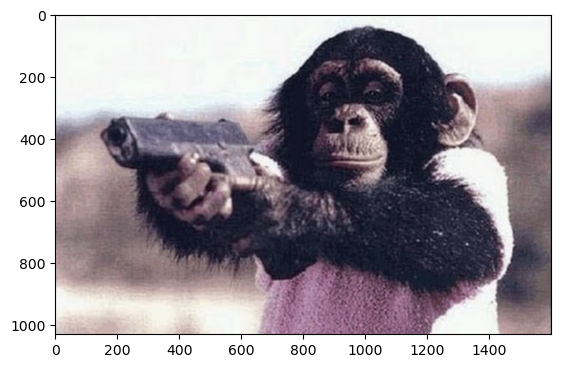

In [7]:
# Load image.
img = image_manager.load_image(img_path)
# Get image representation
img_feats = clip_manager.get_img_feats(img)
# Show the image
plt.imshow(img)
plt.show()

## Zero shot VLM - Image type classification

In [8]:
# Zero-shot VLM: classify image type.
img_types = ['photo', 'cartoon', 'sketch', 'painting']
img_types_feats = clip_manager.get_text_feats([f'This is a {t}.' for t in img_types])
sorted_img_types, img_type_scores = clip_manager.get_nn_text(img_types, img_types_feats, img_feats)
img_type = sorted_img_types[0]
print(f'This is a {img_type}.')

get_text_feats starting!
get_text_feats took 0.4s!
This is a photo.


## Zero shot VLM - Number of people classification

In [9]:
# Zero-shot VLM: classify number of people.
ppl_texts = [
    'are no people', 'is one person', 'are two people', 'are three people', 'are several people', 'are many people'
]
ppl_feats = clip_manager.get_text_feats([f'There {p} in this photo.' for p in ppl_texts])
sorted_ppl_texts, ppl_scores = clip_manager.get_nn_text(ppl_texts, ppl_feats, img_feats)
ppl_result = sorted_ppl_texts[0]

get_text_feats starting!
get_text_feats took 0.3s!


## Zero shot VLM - Image place classification

In [10]:
# Zero-shot VLM: classify places.
place_topk = 3
sorted_places, places_scores = clip_manager.get_nn_text(vocab_manager.place_list, place_feats, img_feats)
print(f'Location: {sorted_places[0]}')

Location: veterinarians office


## Zero shot VLM - Image object classification

In [11]:
# Zero-shot VLM: classify objects.
obj_topk = 10
sorted_obj_texts, obj_scores = clip_manager.get_nn_text(vocab_manager.object_list, object_feats, img_feats)
object_list = ''
for i in range(obj_topk):
    object_list += f'{sorted_obj_texts[i]}, '
object_list = object_list[:-2]
print(f'Top 10 objects recognized: \n{sorted_obj_texts[:10]}')

Top 10 objects recognized: 
['chimpanzee, chimp, Pan troglodytes', 'anthropoid ape', 'lesser ape', 'central chimpanzee, Pan troglodytes troglodytes', 'monkey', 'ape', 'lawgiver, lawmaker', 'simian', 'primate', 'political scientist']


## Finding both relevant and different objects using the cosine similarity

In [15]:
# Create a dictionary that maps the objects to the cosine sim.
object_embeddings = dict(zip(vocab_manager.object_list, object_feats))

# Create a list that contains the objects ordered by cosine sim.
embeddings_sorted = [object_embeddings[w] for w in sorted_obj_texts]

# Create a list to store the best matches
best_matches = [sorted_obj_texts[0]]

# Create an array to store the embeddings of the best matches
unique_embeddings = embeddings_sorted[0].reshape(-1, 1)

# Loop through the 100 best objects by cosine similarity
for i in range(1, 100):
    # Obtain the maximum cosine similarity when comparing object i to the embeddings of the current best matches
    max_cos_sim = (unique_embeddings.T @ embeddings_sorted[i]).max()
    # If object i is different enough to the current best matches, add it to the best matches
    if max_cos_sim < 0.7:
        unique_embeddings = np.concatenate([unique_embeddings, embeddings_sorted[i].reshape(-1, 1)], 1)
        best_matches.append(sorted_obj_texts[i])

# Looping through the best matches, consider each terms separately by splitting the commas and spaces.
data_list = []
for terms in best_matches:
    for term_split in terms.split(', '):
        score = clip_manager.get_image_caption_score(term_split, img_feats)
        data_list.append({
            'term': term_split, 'score': score, 'context': terms
        })
        term_split_split = term_split.split(' ')
        if len(term_split_split) > 1:
            for term_split2 in term_split_split:
                score = clip_manager.get_image_caption_score(term_split2, img_feats)
                data_list.append({
                    'term': term_split2, 'score': score, 'context': terms
                })

# Create a dataframe with the terms and scores and only keep the top term per context.
term_df = pd.DataFrame(data_list).sort_values('score', ascending=False).drop_duplicates('context').reset_index(drop=True)

# Prepare loop to find if additional terms can improve cosine similarity
best_terms_sorted = term_df['term'].tolist()
best_term = best_terms_sorted[0]
terms_to_check = list(set(best_terms_sorted[1:]))
best_cos_sim = term_df['score'].iloc[0]
terms_to_include = [best_term]

# Perform a loop to find if additional terms can improve the cosine similarity
n_iteration = 5
for iteration in range(n_iteration):
    data_list = []
    for term_to_test in terms_to_check:
        new_term = f"{best_term} {term_to_test}"
        score = clip_manager.get_image_caption_score(new_term, img_feats)
        data_list.append({
            'term': new_term, 'candidate': term_to_test, 'score': score
        })
    combined_df = pd.DataFrame(data_list).sort_values('score', ascending=False)
    if combined_df['score'].iloc[0] > best_cos_sim:
        best_cos_sim = combined_df['score'].iloc[0]
        terms_to_include.append(combined_df['candidate'].iloc[0])
        terms_to_check = combined_df['candidate'].tolist()[1:]
        best_term += f" {combined_df['candidate'].iloc[0]}"
    else:
        break

get_text_feats starting!
get_text_feats took 0.1s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.1s!
get_text_feats starting!
get_text_feats took 0.1s!
get_text_feats starting!
get_text_feats took 0.1s!
get_text_feats starting!
get_text_feats took 0.1s!
get_text_feats starting!
get_text_feats took 0.1s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_text_feats took 0.0s!
get_text_feats starting!
get_te

## Zero shot LM - Caption generation

In [ ]:
# Generate 100 captions, order them and print out the best.
num_captions = 100
prompt = f'''Create a creative beautiful caption from this context:
    "This image is a {img_type}. There {ppl_result}.
    The context is: {', '.join(terms_to_include)}.
    A creative short caption I can generate to describe this image is:'''
model_params = {'temperature': 0.9, 'max_length': 40, 'do_sample': True}
caption_texts = flan_manager.generate_response([prompt] * num_captions, model_params)

# Zero-shot VLM: rank captions.
caption_feats = clip_manager.get_text_feats(caption_texts)
sorted_captions, caption_scores = clip_manager.get_nn_text(caption_texts, caption_feats, img_feats)
caption_score_map = dict(zip(sorted_captions, caption_scores))
print(f'Best generate caption"{sorted_captions[0]}"')

generate_response starting!
